# Implementation of a Directional score (multi-class / multi-label)

# MLP

Author : Antony Cellier : cellier@cerfacs.fr

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import helping_modules.pre_treatment as pt
import helping_modules.precision as pr

print('Done')

Using TensorFlow backend.


Done


In [3]:
import keras
keras.__version__
import tensorflow as tf
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

# For GPU allocation 
# Comment when running on CPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

print('Done')

Done


In [4]:
from keras.utils import np_utils
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print('Done')

Done


# LOAD INPUTS / TARGETS

In [5]:
Inputs_train = np.load('../DATA/inputs_targets/INPUTS_TRAIN_STATS.npy')
Targets_train = np.load('../DATA/inputs_targets/TARGETS_TRAIN_STATS.npy')
Inputs_test = np.load('../DATA/inputs_targets/INPUTS_TEST_STATS.npy')
Targets_test = np.load('../DATA/inputs_targets/TARGETS_TEST_STATS.npy')
Inputs_valid = np.load('../DATA/inputs_targets/INPUTS_VALID_STATS.npy')
Targets_valid = np.load('../DATA/inputs_targets/TARGETS_VALID_STATS.npy')

# BUILD THE NETWORK

In [6]:
N_t = Inputs_train.shape[1]
N_channel = Inputs_train.shape[2]
batch_size = 256

print('Done')

Done


In [ ]:
K.clear_session()


model = models.Sequential()

#Flatten layer
model.add(layers.Flatten(input_shape=(N_t, N_channel)))

#First Dense layer
model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

#Second Dense layer
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

#Output layer
model.add(layers.Dense(4, activation='sigmoid'))

model.summary()

# SET TRAINING PARAMETERS

Do not forget to check the version of training you are starting, avoid overwriting on an old version to keep.

In [ ]:
#Number of epochs
N_f = 100
#Frequency of network save
N_save = 1
Version = 'V3'

adam = optimizers.Adam(lr=0.00005)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

print('Done')

# TRAIN

It may take a while depending on your hardware.

A trained network is available to continue.

In [ ]:
callbacks = [ModelCheckpoint(filepath='saved_models_MLP/MLP_model_{epoch:02d}ep_' + Version + '.h5', verbose=0, period=N_save), ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, verbose=1)]

history=model.fit(Inputs_train, Targets_train, epochs=N_f, callbacks=callbacks, batch_size=batch_size, validation_data=(Inputs_valid, Targets_valid))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
    
history_f = np.array([acc, val_acc, loss, val_loss])
    
np.save('saved_models_MLP/History_Save_MLP_' + str(N_f) + 'ep_' + Version + '.npy', history_f)
    
epochs = range(N_f)
    
acc_plot = history_f[0,:]
val_acc_plot = history_f[1,:]
loss_plot = history_f[2,:]
val_loss_plot = history_f[3,:]

plt.plot(epochs, val_loss_plot, 'b', label='Validation loss')
plt.plot(epochs, loss_plot, 'r', label='Training loss')
plt.title('Loss')
plt.grid(axis='both')
plt.legend()
plt.show()

# LOAD A MODEL

Best loss at :  42 Epochs ( 0.5489640094615795 )
Best accuracy at :  77 Epochs ( 0.8005864200474303 )
Model loaded :  42 Epochs
Model specs : VAL LOSS :  0.5489640094615795 , VAL ACC :  0.797993827543141


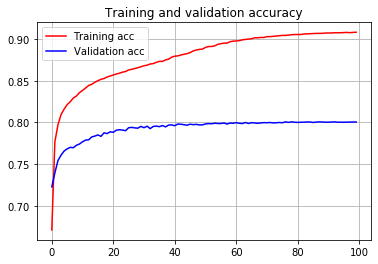

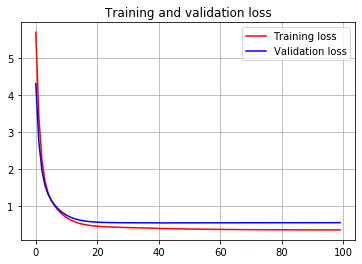

Done


In [7]:
# import a model to evaluate

N_f = 100
N_save = 1

Version = 'V2'
optim = 'loss'

# load and plot its history

History_eval = np.load('saved_models_MLP/History_Save_MLP_' + str(N_f) + 'ep_' + Version + '.npy')

acc = History_eval[0]
val_acc = History_eval[1]
loss = History_eval[2]
val_loss = History_eval[3]

N_lim = 100

Optim_loss = (np.argmin(val_loss[N_save-1:N_lim:N_save])+1)*N_save
Optim_acc = (np.argmax(val_acc[N_save-1:N_lim:N_save])+1)*N_save
print('Best loss at : ', Optim_loss, 'Epochs (', val_loss[Optim_loss-1], ')')
print('Best accuracy at : ', Optim_acc, 'Epochs (', val_acc[Optim_acc-1], ')')

if optim == 'loss':
    
    Ind = Optim_loss
    print('Model loaded : ', Ind, 'Epochs')
    print('Model specs : VAL LOSS : ', val_loss[Ind-1], ', VAL ACC : ', val_acc[Ind-1])

    model_eval = models.load_model('saved_models_MLP/MLP_model_' + str(Ind) + 'ep_' + Version + '.h5')
    
else:
    
    Ind = Optim_acc
    print('Model loaded : ', Ind, 'Epochs')
    print('Model specs : VAL LOSS : ', val_loss[Ind-1], ', VAL ACC : ', val_acc[Ind-1])

    model_eval = models.load_model('saved_models_MLP/MLP_model_' + str(Ind) + 'ep_' + Version + '.h5')


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

print('Done')

# EVALUATE PERFORMANCES

In [8]:
# Evaluate the model on test data

batch_test = batch_size
test_loss, test_acc = model_eval.evaluate(Inputs_test, Targets_test, batch_size=batch_test)
print('test acc :', test_acc)
print('test loss (regularized) :', test_loss)

8400/8400 [==============================] - 1s 72us/step
test acc : 0.7967261909303212
test loss : 0.5338977630933126


In [9]:
Y_V = model_eval.predict(Inputs_valid)
Y_T = model_eval.predict(Inputs_test)

In [10]:
print('Valid Loss : ', pr.Loss_Calc(Y_V, Targets_valid))
print('Valid Acc : ', pr.Acc_Calc(np.floor(Y_V+0.5), Targets_valid))
print('Test Loss : ', pr.Loss_Calc(Y_T, Targets_test))
print('Test Acc : ', pr.Acc_Calc(np.floor(Y_T+0.5), Targets_test))

Valid Loss :  0.4524054317751054
Valid Acc :  0.7979938271604938
Test Loss :  0.4373391837363306
Test Acc :  0.7967261904761904


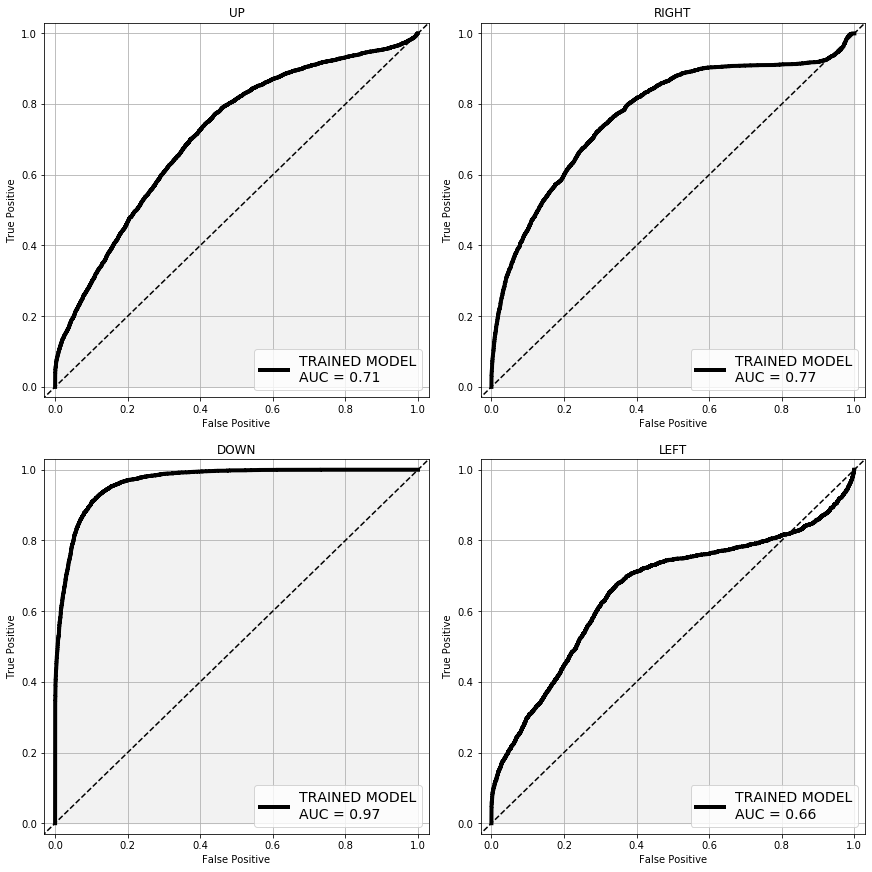

In [11]:
Legend = ['TRAINED MODEL']

NT = Targets_valid.shape[0] + Targets_test.shape[0]

Targets = np.zeros((1, NT, 4))
Pred_proba = np.zeros((1, NT, 4))

Targets[0, :, :] = np.concatenate([Targets_valid, Targets_test])
Pred_proba[0, :, :] = np.concatenate([Y_V, Y_T])

pr.ROC(Targets, Pred_proba, Legend)